## IOU: intersection over union of two plot

### content:
- do ica on different sessions of data
- edit zbinarized ic to diminish the influence of noise points
- calculate intersection over union of two plot
- test iou funtion on ics

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects
from Analysis import *
import Draw
import Interface
from os.path import join as pjoin

In [3]:
#parameters
stimuli = 'baseline'
mouse = 'H78'
date = '240620'
data_path = f'/home/qqy/data/WF_VC_liuzhaoxi/npy_data/{stimuli}_{mouse}_{date}'
path_wfield = r'/home/qqy/data/WF_VC_liuzhaoxi/24.06.20_H78/baseline/process/20240620-172539-wfield'
size1= 512
size2 = 512
threshold = 2.0

In [4]:
#load data
interface = Interface.Interface()
data = np.load(data_path+'.npy')
interface.add_from_file('fa', pjoin(path_wfield,'frames_average.npy'))
interface.add_from_file('dorsal', pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))

In [5]:
#ica from start to end
def session_ica(data,n_component,start,end,v=False):
    """
    data: (time,size1*size2)

    """
    data = data[start:end]
    ic,mix = ica(data,n_component,v=v)
    return ic,mix

In [6]:
print(data.shape)

(620, 262144)


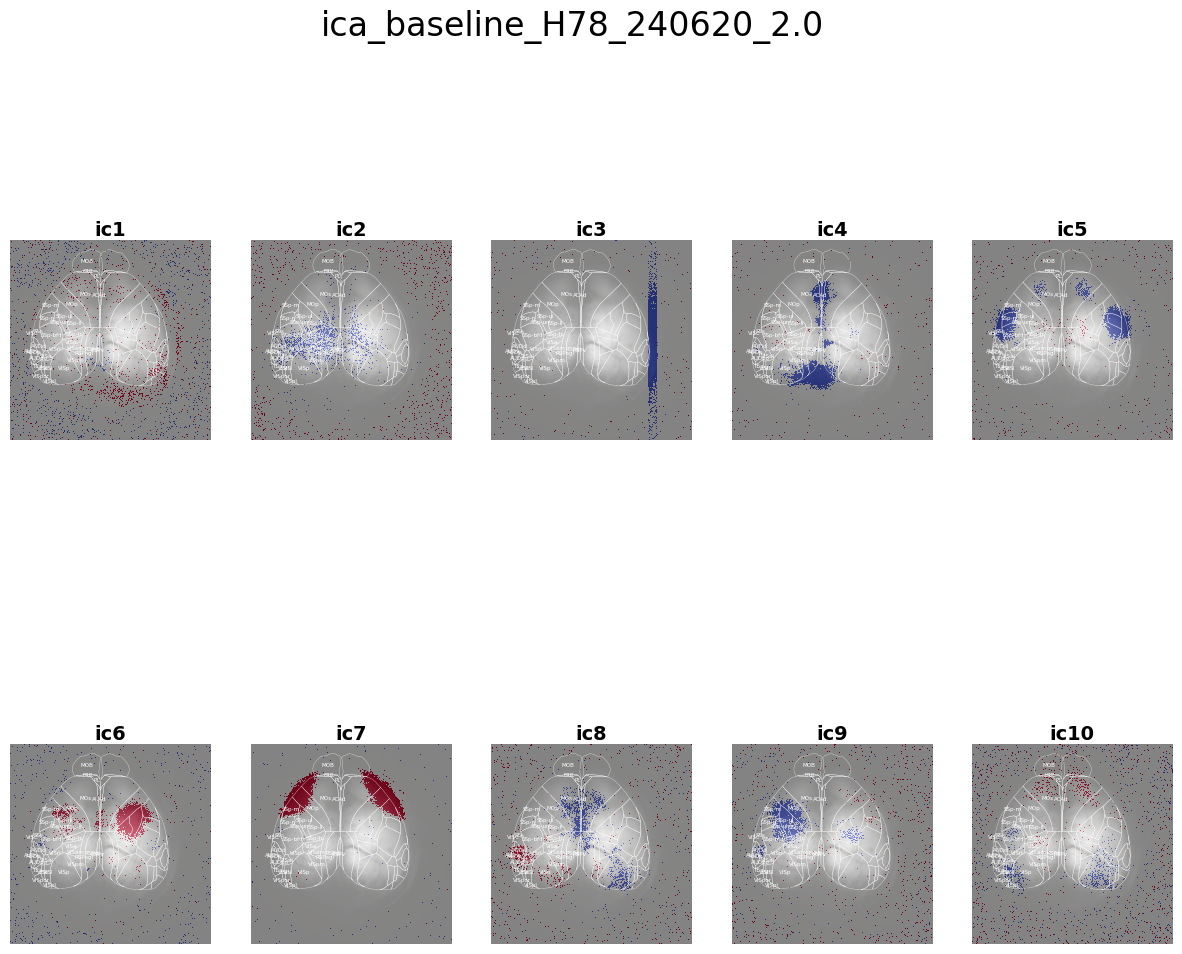

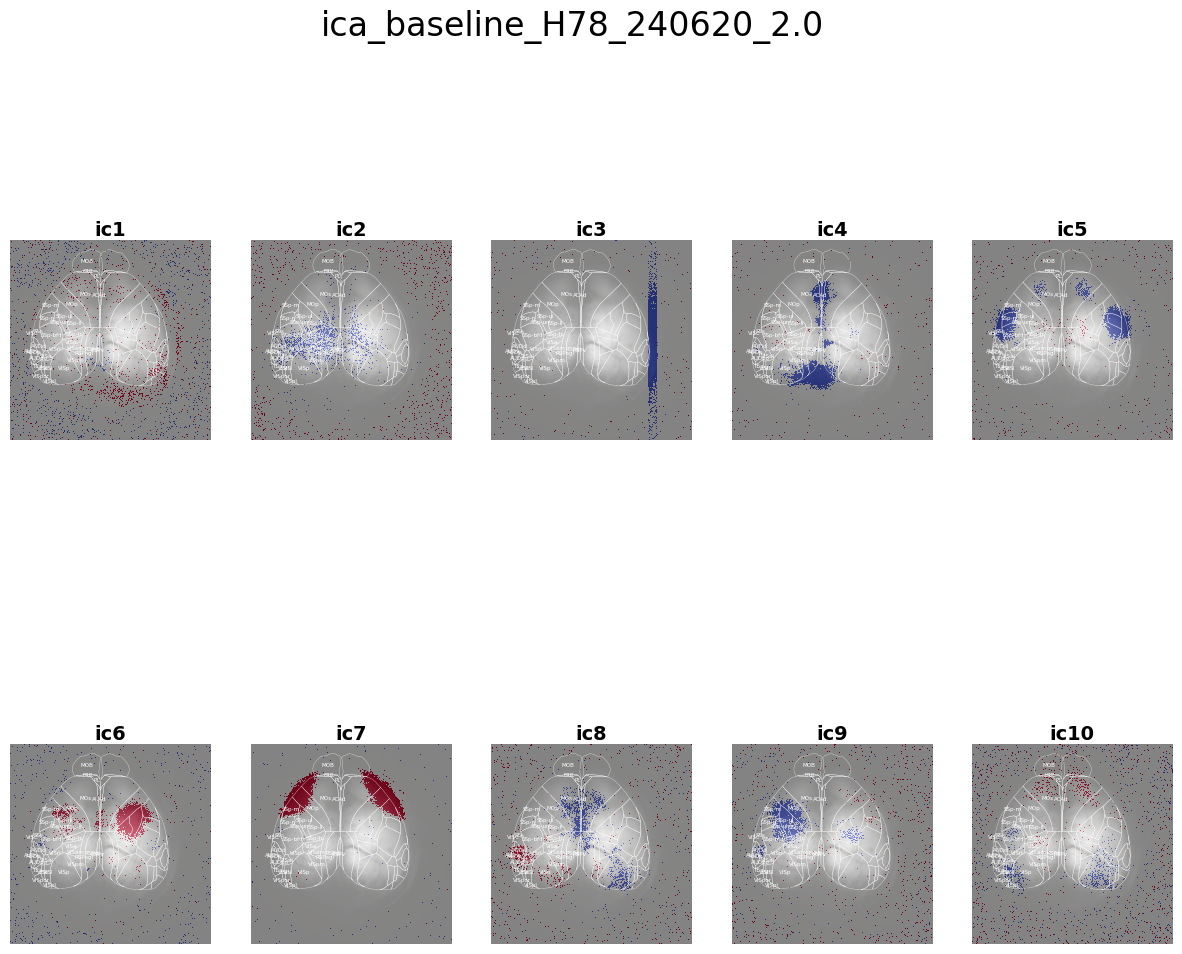

In [7]:
#ica1 and plot ic1s
ic1,mix1 = session_ica(data,10,0,200,v=True)
reshaped_ic1 = ic1.reshape(ic1.shape[0],size1,size2)
Draw.zbinary_plot(reshaped_ic1,2,5,[f'ic{i+1}' for i in range(10)], ccf_regions=interface.get('dorsal'), frames_average=interface.get('fa')[0]
                    ,title=f'ica_{stimuli}_{mouse}_{date}_{threshold}',path_outfile=None,alpha=0.6
                    ,threshold=threshold)

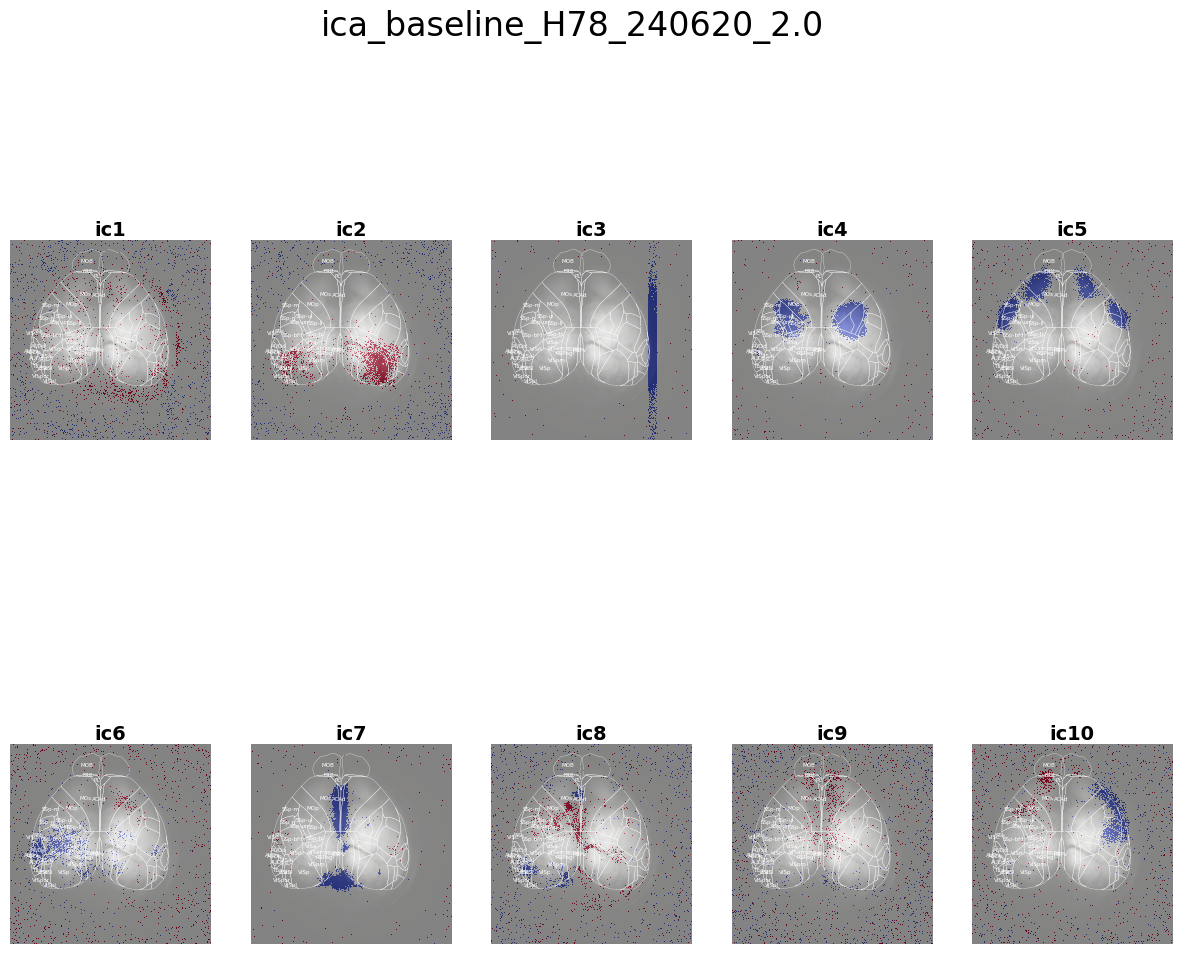

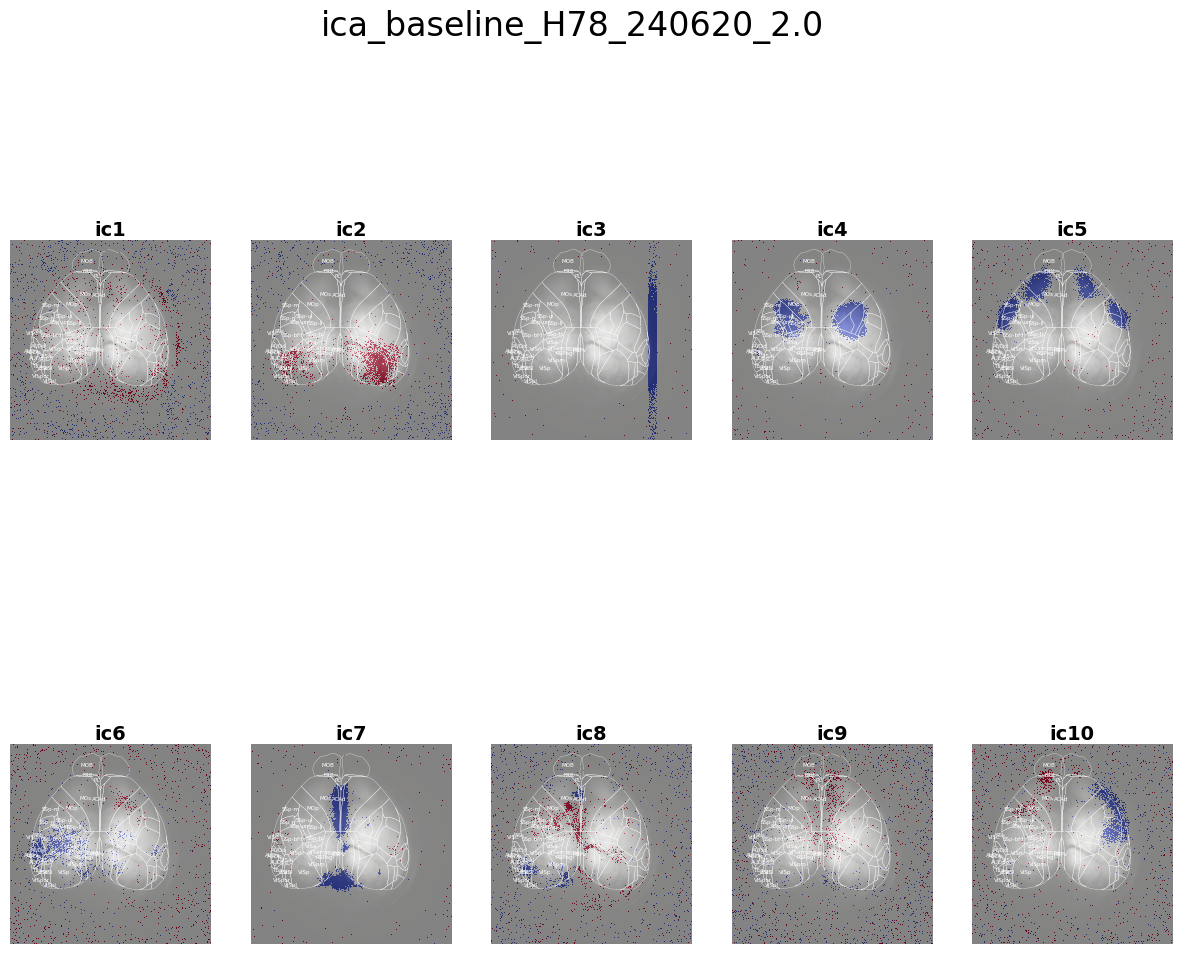

In [8]:
#ica2 and plot ic2s
ic2,mix2 = session_ica(data,10,200,400,v=True)
reshaped_ic2 = ic2.reshape(ic2.shape[0],size1,size2)
Draw.zbinary_plot(reshaped_ic2,2,5,[f'ic{i+1}' for i in range(10)], ccf_regions=interface.get('dorsal'), frames_average=interface.get('fa')[0]
                    ,title=f'ica_{stimuli}_{mouse}_{date}_{threshold}',path_outfile=None,alpha=0.6
                    ,threshold=threshold)

In [9]:
##find cluster

def find_cluster(binary_image,area):

    labeled_array, num_features = label(binary_image)
    print(f'num_features: {num_features}')
    objects = find_objects(labeled_array)
    new_binary_image = np.zeros_like(binary_image)
    for i in range(1,num_features+1):
        cluster = (labeled_array == i)
        new_binary_image[cluster] = cluster.sum()>=area
        # if cluster.sum()>=area:
        #     binary_image[cluster] == 1
        # else:
        #     binary_image[cluster] == 0
    return new_binary_image

In [10]:
#zbinary ic
zb_ic1 = np.zeros_like(reshaped_ic1)
zb_ic2 = np.zeros_like(reshaped_ic2)
for i in range(ic1.shape[0]):
   zb_ic1[i] = make_mask(reshaped_ic1[i],size1,size2,threshold,show=False)
   zb_ic2[i] = make_mask(reshaped_ic2[i],size1,size2,threshold,show=False)

In [15]:
#find cluster
area = 50
cluster_ic1 = np.zeros_like(zb_ic1)
cluster_ic2 = np.zeros_like(zb_ic2)
for i in range(zb_ic1.shape[0]):
    cluster_ic1[i] = find_cluster(zb_ic1[i],area)


for i in range(zb_ic2.shape[0]):
    cluster_ic2[i] = find_cluster(zb_ic2[i],area)


num_features: 10444
num_features: 7924
num_features: 2049
num_features: 2237
num_features: 3457
num_features: 4254
num_features: 1528
num_features: 6899
num_features: 5958
num_features: 9648
num_features: 10378
num_features: 7296
num_features: 1110
num_features: 1712
num_features: 3520
num_features: 7357
num_features: 1547
num_features: 7983
num_features: 10255
num_features: 7325


In [12]:
def IOU(cluster1,cluster2):
    """
    cluster1: binary image
    cluster2: binary image
    """
    intersection = np.logical_and(cluster1,cluster2).sum()
    union = np.logical_or(cluster1,cluster2).sum()
    if union == 0:
        return 0
    return intersection/union

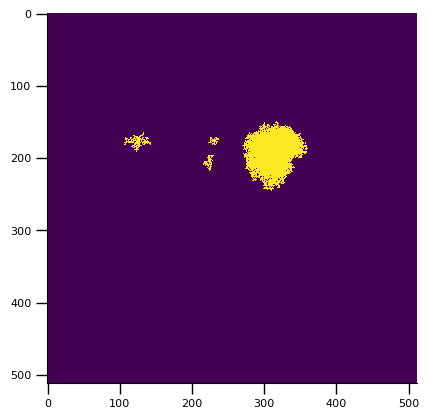

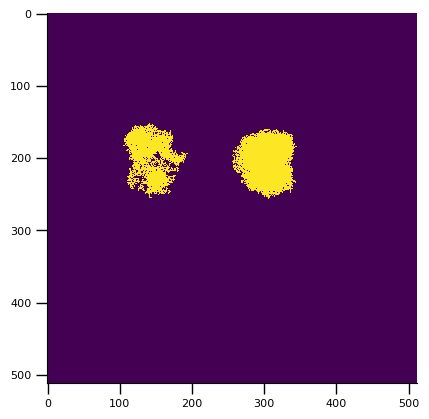

In [19]:
plt.imshow(cluster_ic1[5])
plt.show()
plt.imshow(cluster_ic2[3])
plt.show()

In [29]:
matrix1 = np.zeros((cluster_ic1.shape[0],cluster_ic2.shape[0]))
for i in range(ic1.shape[0]):
    for j in range(ic2.shape[0]):
        matrix1[i,j] = IOU(cluster_ic1[i],cluster_ic2[j])

In [33]:
#delete noise term
matrix1[2,2] = 0.

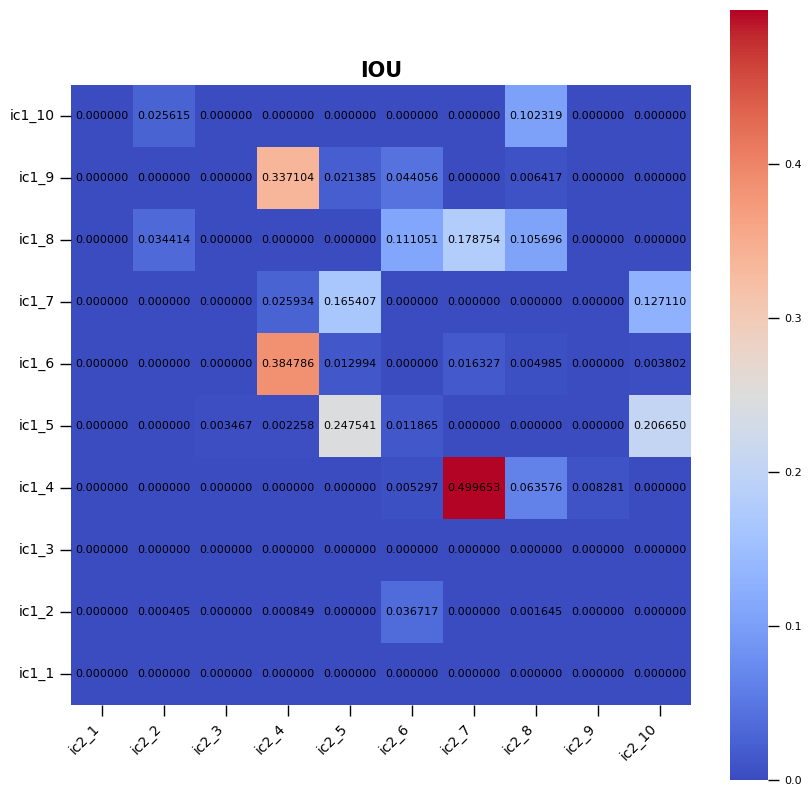

In [35]:
Draw.plot_heatmap(matrix1, xlable=[f'ic2_{i+1}' for i in range(ic2.shape[0])], ylable=[f'ic1_{i+1}' for i in range(ic1.shape[0])], title='IOU')